# Laboratorio de predicción lineal

## Intentaremos aplicar predicción lineal sobre señales de voz.
## Sabiendo que las señales de voz pueden ser modeladas con un modelo autorregresivo:

In [1]:
%pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=77fa91963e901de0e5a4dee611dbae9353d6a5aba51bab945c4464d39b3b4264
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import wget
import scipy.io.wavfile as wave
import IPython
from scipy.linalg import toeplitz, inv

### 1. Realizar una grabación de duración T = 2 s y fs = 8 kHz de los sonidos /a/ y /sh/.

In [3]:
a_url = 'https://raw.githubusercontent.com/ManuMollon261297/PASA/master/TP3/recordings/a.wav'
a_file = wget.download(a_url)

sh_url = 'https://raw.githubusercontent.com/ManuMollon261297/PASA/master/TP3/recordings/sh.wav'
sh_file = wget.download(sh_url)

In [4]:
fs, a_arr = wave.read(a_file)
#Bajo fs a 8KHz
desired_fs = 8000
final_len = int(len(a_arr) * (8000/fs))
resampled_a = sig.resample(a_arr, final_len)

print("fs = "+str(desired_fs))
print("Number of samples = "+ str(len(resampled_a)))
IPython.display.Audio(resampled_a,rate=desired_fs)

fs = 8000
Number of samples = 20640


In [5]:
fs, sh_arr = wave.read(str(sh_file))

#Bajo fs a 8KHz
desired_fs = 8000
final_len = int(len(sh_arr) * (8000/fs))
resampled_sh = sig.resample(sh_arr, final_len)

print("fs = "+str(desired_fs))
print("Number of samples = "+ str(len(resampled_sh)))
IPython.display.Audio(resampled_sh,rate=desired_fs)

fs = 8000
Number of samples = 19616


### 2. Para ambos sonidos, realizar la predicción forward con N0 = 1, y representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.

In [51]:
def autocorreltion(x):
  norm_x = (x - x.mean())/(abs(x).max())
  return np.correlate(norm_x,norm_x,mode='full') / len(x)

def LevinsonDurbin(r,debug = False):
  last_delta = np.conj(r[1])
  a_coefs = 1
  M = len(r)
  P_values = []
  P_values.append(r[0])
  for i in range(1,M):
    k = (-last_delta) / P_values[-1]
    last_coefs = a_coefs
    a_coefs = np.ones(i+1, dtype= np.float64)
    a_coefs[-1] = k 
    if (i>1):
      a_coefs[1:-1] = last_coefs[1:] + k*np.flip(np.conj(last_coefs[1:]))
    P_values.append( P_values[-1] * (1- (abs(k)**2) ) )
    last_delta = np.dot(np.flip(r[0:i+1]),a_coefs)
    if debug:
      print("m = "+str(i))
      print("a_coefs:",a_coefs)
      print("p = "+str(P_values[-1]))
      print("k = "+str(k))
      print("delta = ")
      print(last_delta)
  return a_coefs,P_values


In [44]:
#Testeo de Levinson Durbin
M=4
r = autocorreltion(resampled_a)
r = r[r.argmax():r.argmax()+M]
print("r:",r)
LevinsonDurbin(r,debug = True)

r: [0.02368022 0.02105136 0.01541871 0.0103042 ]
m = 1
a_coefs: [ 1.         -0.88898508]
p = 0.004965873222952788
k = -0.8889850810340105
delta = 
0.0
m = 2
a_coefs: [ 1.         -0.88898508 -0.        ]
p = 0.004965873222952788
k = -0.0
delta = 
-0.0032956337081812472
m = 3
a_coefs: [ 1.         -0.88898508 -0.58998067  0.66365643]
p = 0.002778704712830769
k = 0.6636564326589092
delta = 
-0.0001071687473708817


array([ 1.        , -0.88898508, -0.58998067,  0.66365643])

m = 1
a_coefs: [ 1.         -0.88898508]
p = 0.004965873222952788
k = -0.8889850810340105
delta = 
0.0
m = 2
a_coefs: [ 1.         -0.88898508 -0.        ]
p = 0.004965873222952788
k = -0.0
delta = 
-0.0032956337081812472
m = 3
a_coefs: [ 1.         -0.88898508 -0.58998067  0.66365643]
p = 0.002778704712830769
k = 0.6636564326589092
delta = 
-0.0001071687473708817
m = 4
a_coefs: [ 1.         -0.86338926 -0.61273497  0.62937016  0.03856788]
p = 0.0027745714415407284
k = 0.03856787908266256
delta = 
0.003660316723872363
m = 5
a_coefs: [ 1.         -0.91426943 -1.44302325  1.43771268  1.17758276 -1.31923679]
p = -0.00205425304589788
k = -1.3192367906157707
delta = 
0.001965866823382529
m = 6
a_coefs: [ 1.         -2.17674478 -0.31610713  2.81356638 -0.20335302 -2.19416889
  0.95697403]
p = -0.0001729695423911594
k = 0.9569740336070823
delta = 
-0.007965165224155961
m = 7
a_coefs: [   1.          -46.24494423  100.72432749   12.17787632 -129.76674777
   12.36241403  101.19503656  -46.04952

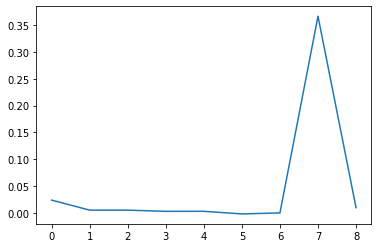

In [54]:
M=9
r = autocorreltion(resampled_a)
r = r[r.argmax():r.argmax()+M]
_, p_list = LevinsonDurbin(r,debug=True)
plt.plot(p_list)
print(p_list)

### 3. Para ambos sonidos, analizar cualitativa- y cuantitativamente la señal del error de predicción y el espectro H(ejω) de filtro autorregresivo estimado para M = 1, 6, 12, 24, 100. Comparar este espectro con el espectro obtenido por estimación no-paramétrica.

### 4. ¿Cuál es el orden óptimo Mo para cada sonido?

### 5. Sintetizar los sonidos aplicando el filtro autorregresivo estimado de orden Mo a una excitación apropiada.

### 6. Para el sonido /a/ y con Mo, realizar la recursión de Levinson-Durbin y representar los coeficientes κm en función de m.